### Q1.2

Image successfully read...
Finding Corners...


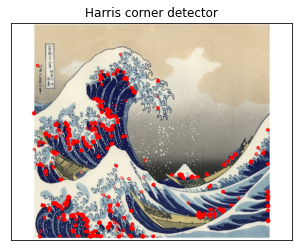

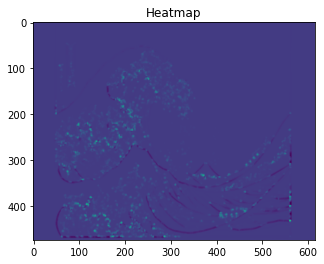

In [1]:
import cv2
import numpy as np
import glob
import os
from os import listdir
from pydist2.distance import pdist2
import matplotlib.pyplot as plt 
%matplotlib inline 


def harris_corner(img_dir,window_size,k,threshold):

    img = cv2.imread(img_dir)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    gray = np.float32(gray)

    img_gaussian = cv2.GaussianBlur(gray,(3,3),0)

    #Check if the image exists
    if img is None:
        print('Invalid image:' + img_dir)
        return None
    else:
        print('Image successfully read...')
        
    height = img.shape[0] 
    width = img.shape[1]  
    matrix_R = np.zeros((height, width))
    
    #Calculate the x and y image derivatives (dx and dy)
    dx = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3)

    #Calculate product and second derivatives (dx2, dy2 and dxy)
    dx2=np.square(dx)
    dy2=np.square(dy)
    dxy=dx*dy
    
    offset = int( window_size / 2 )
    #Compute the sums of the products of derivatives ateach pixel
    print ("Finding Corners...")
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            Sx2 = np.sum(dx2[y-offset:y+1+offset, x-offset:x+1+offset])
            Sy2 = np.sum(dy2[y-offset:y+1+offset, x-offset:x+1+offset])
            Sxy = np.sum(dxy[y-offset:y+1+offset, x-offset:x+1+offset])

            #Define the matrix H(x,y)=[[Sx2,Sxy],[Sxy,Sy2]]
            H = np.array([[Sx2,Sxy],[Sxy,Sy2]])

            #Calculate the response function ( R=det(H)-k(Trace(H))^2 )
            det=np.linalg.det(H)
            tr=np.matrix.trace(H)
            R=det-k*(tr**2)
            matrix_R[y-offset, x-offset]=R
    
    # Apply a threshold
    cv2.normalize(matrix_R, matrix_R, 0, 1, cv2.NORM_MINMAX)
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            value=matrix_R[y, x]
            if value>threshold:
                cv2.circle(img,(x,y),3,(0,0,255))
                
    #saving detected corners and visualising them
    plt.figure("Harris corner detector")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Harris corner detector")
    plt.xticks([]), plt.yticks([])
    plt.savefig('q1_2_corners.jpg', bbox_inches='tight')
    plt.show()
        
    #visualising and saving heatmap
    plt.figure("Heatmap")
    plt.imshow(matrix_R), plt.title("Heatmap")
    plt.savefig('q1_2_heatmap.jpg', bbox_inches='tight')
    plt.show()
    
if __name__ == "__main__":
    harris_corner("objects/objet1.jpg", 5, 0.04, 0.30) 

### QUESTION 2

In [2]:
def sift(im1):
    grayIm = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    keypoints1, descriptors1 = sift.detectAndCompute(grayIm,None)
    
    return keypoints1, descriptors1
    
if __name__ == "__main__":
        
    #defining images directory path
    imageDirectory = "sift/data/" # Enter Directory of all images  
    data_path = os.path.join(imageDirectory,'*g') 
    files1 = glob.glob(data_path)
    
    #iterating through a directory of image files
    for f1 in files1: 
        im1 = cv2.imread(f1)
        
        #calling sift function for this image
        keypoints1, descriptors1 = sift(im1)
                
        #saving descriptors
        name = f1+".npz"
        np.savez(name, desc=descriptors1)
    

In [3]:
#testing saved variables in Question 2
descriptors = np.load("sift/data/img3.jpg.npz")
desc1 = descriptors["desc"]
print(desc1)

[[  8.  84.  49. ...  62.   1.   1.]
 [ 78.  71.   0. ...   0.   0.   0.]
 [  9. 102.  18. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   4.  22.  34.]
 [  0.   1.  70. ...   8.  35.  45.]
 [  0.   0.   0. ...  33.  19.   0.]]


### QUESTION 3.1

In [4]:
def matchsift(D1, D2, th):
    
    # Initialize variables
    matches = []
        
    # Loop over the number of features in the first image
    for i in range(D1.shape[0]):
        # Calculate the euclidean distance between feature vector i in 1st image and all other feature vectors
        # second image
        dists = np.sqrt(((D1[i,:]-D2)**2).sum(axis = 1))

        # sort the dists in ascending order, while retaining the index of that distance
        sort_dist = np.argsort(dists)
        
        #comparing the ratio to threshold 0.8
        if (dists[sort_dist[0]] / dists[sort_dist[1]]<0.8):
        # append the index of D1, and its corresponding best matching D2's index
            matches.append([i, sort_dist[0]])
    
    return matches, dists

#Computing keypoints and descriptors
def computePointsAndDescriptors(imgFile):
    
    #Computing keypoints and descriptors
    img = cv2.imread(imgFile)
    grayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    keypoints, descriptors = sift.detectAndCompute(grayImg,None)
    
    return keypoints, descriptors

if __name__ == "__main__":
    th = 0.8
    
    #Directory for training images
    imageDirectory = "objects/" # Enter Directory of all images
    data_path = os.path.join(imageDirectory,'*g') 
    files1 = glob.glob(data_path)
    
    #Directory for testing images
    imageDirectory2 = "images_test/" # Enter Directory of all images
    data_path2 = os.path.join(imageDirectory2,'*g') 
    files2 = glob.glob(data_path2)
    
    #iterating through images in objects directory
    for f1 in files1: 
        kpts1, descps1 = computePointsAndDescriptors(f1)
        D1 = descps1
        
        #iterating through images in images_test directory
        for f2 in files2: 
            kpts2, descps2 = computePointsAndDescriptors(f2)
            D2 = descps2
            
            matches, dists = matchsift(D1, D2,th)
            
            print("Printing matches between "+str(f1)+" and "+str(f2)+":")
            print(matches)
            print()
            
            print("Printing distances between "+str(f1)+" and "+str(f2)+":")
            print(dists)
            print()
    

Printing matches between objects\objet1.jpg and images_test\0001.jpg:
[[19, 373], [29, 388], [36, 479], [38, 358], [42, 374], [46, 376], [69, 397], [73, 530], [84, 1327], [110, 368], [115, 380], [119, 402], [120, 403], [123, 361], [124, 362], [144, 391], [156, 433], [178, 42], [181, 389], [194, 412], [206, 400], [209, 439], [234, 381], [244, 406], [274, 399], [278, 430], [285, 372], [286, 383], [293, 427], [294, 393], [300, 422], [302, 395], [306, 411], [336, 419], [337, 454], [373, 447], [375, 451], [377, 461], [383, 415], [384, 416], [385, 423], [398, 424], [400, 420], [401, 421], [404, 431], [405, 432], [410, 459], [418, 428], [422, 435], [423, 436], [424, 464], [425, 465], [426, 469], [432, 440], [449, 479], [451, 457], [474, 493], [476, 492], [481, 108], [500, 480], [509, 472], [511, 494], [517, 499], [518, 457], [528, 496], [531, 467], [549, 507], [556, 500], [567, 491], [570, 516], [572, 489], [575, 482], [576, 473], [582, 509], [599, 536], [601, 478], [602, 479], [605, 486], [6

### QUESTION 3.2

In [6]:
#drawing matches
def drawMatches(img1, img2, kpts1, kpts2, matches, f1):
        
        #creating matched image file
        fno  = str(f1).strip("images_test\\\\")
        matchedImage = "q3_2_match"+fno+"g"
       
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
        image3 = np.column_stack((img1, img2))
        for i, j in matches:
            x1, y1 = kpts1[i].pt[:2]
            x2, y2 = kpts2[j].pt[:2]
            x2 = x2 + img1.shape[1]

            cv2.line(image3, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        
        #saving the image
        cv2.imwrite(matchedImage,image3)
        
        cv2.imshow("Matches", image3)
        cv2.waitKey(0)

#computing matches
def matchsift3(D1, D2, th):
    # Initialize variables
    matches = []
    match_count = 0  
    
    # Loop over the number of features in the first image
    for i in range(D1.shape[0]):
        # Calculate the euclidean distance between feature vector i in 1st image and all other feature vectors
        # second image
        dists = np.sqrt(((D1[i,:]-D2)**2).sum(axis = 1))

        # sort the dists in ascending order, while retaining the index of that distance
        sort_dist = np.argsort(dists)
        
        #comparing the ratio to threshold 0.8
        if (dists[sort_dist[0]] / dists[sort_dist[1]]<0.8):
        # append the index of D1, and its corresponding best matching D2's index
            matches.append([i, sort_dist[0]])
            match_count = match_count+1
 
    return matches, dists, match_count

#computing keypoints and descriptors
def computePointsAndDescriptors3(imgFile):
    #Computing keypoints and descriptors
    img = cv2.imread(imgFile)
    grayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    keypoints, descriptors = sift.detectAndCompute(grayImg,None)
    
    return keypoints, descriptors, img

if __name__ == "__main__":
    th = 0.8
    
    #Directory for training images
    imageDirectory = "objects/" 
    data_path = os.path.join(imageDirectory,'*g') 
    files1 = glob.glob(data_path)
    
    #Directory for testing images
    imageDirectory2 = "images_test/" 
    data_path2 = os.path.join(imageDirectory2,'*g') 
    files2 = glob.glob(data_path2)
    
    #iterating through images in objects directory
    testImgCount = 0
    for f1 in files1: 
        kpts1, descps1, img1 = computePointsAndDescriptors3(f1)
        D1 = descps1
        
        temp_count = 0
        #iterating through images in images_test directory
        for f2 in files2: 
            kpts2Temp, descps2, img2Temp = computePointsAndDescriptors3(f2)
            D2 = descps2
            testImgCount = testImgCount+1
            matchesTemp, dists, match_count = matchsift3(D1, D2,th)
            
            #comparing current iteration match count and previous match count
            if(match_count>temp_count):
                temp_count = match_count
                kpts2 = kpts2Temp
                matches = matchesTemp
                img2 = img2Temp
                fname = f2  
                
        #calling function to draw matches
        drawMatches(img1, img2, kpts1, kpts2, matches, fname)

        
        